In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import shap

import warnings
warnings.filterwarnings("ignore")

print("Début du notebook.")

Début du notebook.


In [ ]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train_cat.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test_cat.csv").squeeze()
X_train = X_train.drop(columns=["z (Wh/km)", "Erwltp (g/km)", "Fuel consumption", "Electric range (km)"])
X_test = X_test.drop(columns=["z (Wh/km)", "Erwltp (g/km)", "Fuel consumption", "Electric range (km)"])

In [ ]:
xgb_best = XGBClassifier(n_estimators= 356, max_depth= 7, learning_rate= 0.14699288405576386, subsample= 0.7800973218836108, colsample_bytree= 0.8132027133571144,
                      gamma= 0.40423186849963505, min_child_weight= 6, reg_alpha= 0.9751765741117663, reg_lambda= 1.5152270871434224)
xgb_best.fit(X_train, y_train)



## SHAP du XGB_best

Test F1 (weighted): 0.9277690302785863
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11665
           1       0.99      1.00      1.00     10098
           2       0.87      0.85      0.86      6891
           3       0.91      0.92      0.91     25541
           4       0.88      0.90      0.89     20451
           5       0.93      0.91      0.92     18592
           6       0.95      0.94      0.94      9811
           7       0.95      0.95      0.95      3158

    accuracy                           0.93    106207
   macro avg       0.93      0.93      0.93    106207
weighted avg       0.93      0.93      0.93    106207



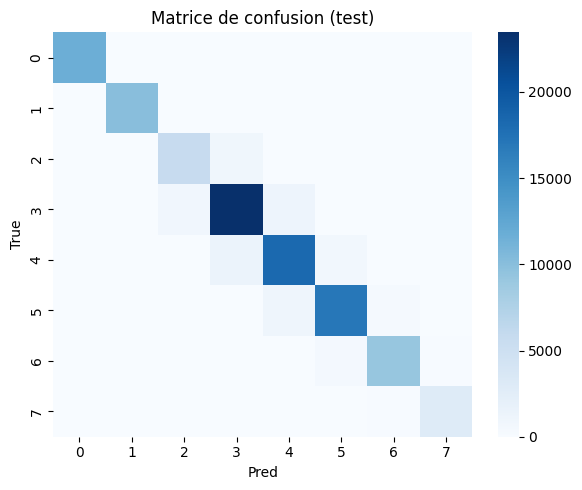


Top 20 importance (gain):


Ft_ELECTRIC          3543.706787
Ft_PETROLPHEV        1385.981934
Fm_E                  665.505371
Ft_DIESELPHEV         311.322906
Fm_P                  108.086815
ec (cm3)              100.132469
Ft_PETROLELECTRIC      72.920021
Fm_F                   72.832771
Fm_H                   68.460449
Ft_PETROL              65.201988
Cr_M1G                 56.128819
ep (KW)                41.572922
Ft_HYDROGEN            39.602661
m (kg)                 39.598667
IT                     34.152302
At1 (mm)               31.214884
W (mm)                 27.398220
Fm_M                   23.392092
Ft_E85                 21.488998
Ft_NG                  14.628716
dtype: float64

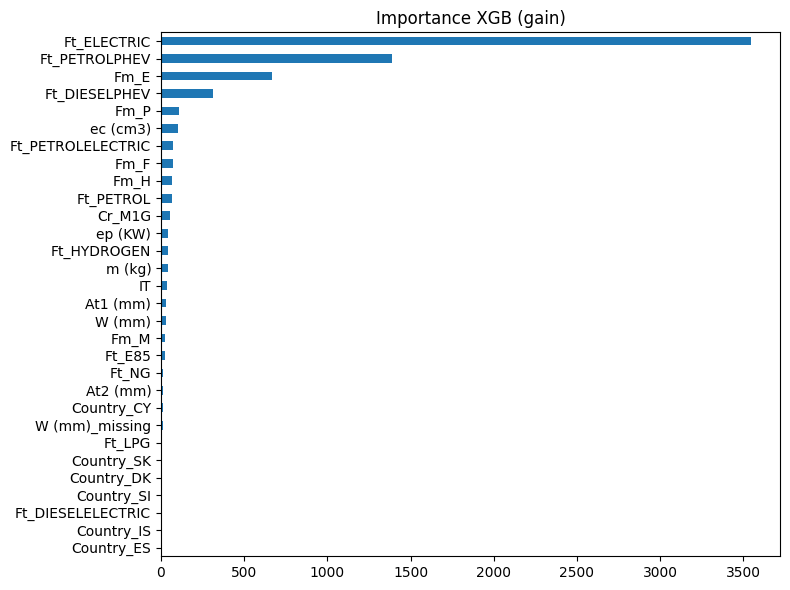


Top 20 permutation importance (F1 weighted):


m (kg)            0.354395
ec (cm3)          0.255245
ep (KW)           0.105083
W (mm)            0.087706
Ft_PETROLPHEV     0.071810
At1 (mm)          0.041129
Fm_P              0.040545
Ft_PETROL         0.034562
At2 (mm)          0.029733
IT                0.009644
Fm_H              0.009338
Fm_F              0.007130
Cr_M1G            0.004167
Country_DE        0.002048
Country_SK        0.001207
Country_ES        0.000876
Country_PL        0.000855
W (mm)_missing    0.000815
Country_DK        0.000795
Country_SI        0.000548
dtype: float64

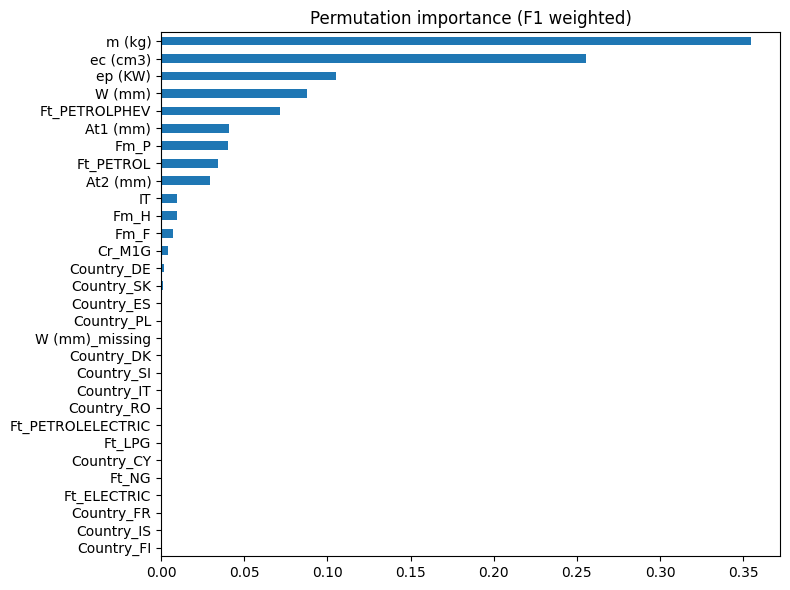

In [ ]:
# Modèle à expliquer
final_model = xgb_best  # change si besoin

# Échantillon pour SHAP/PDP
rng = np.random.default_rng(42)
sample_size = min(20000, len(X_test))
idx = rng.choice(len(X_test), size=sample_size, replace=False)
X_exp = X_test.iloc[idx]
y_exp = np.ravel(y_test)[idx]

# 1) Rapport global + matrice de confusion
y_pred = final_model.predict(X_test)
print("Test F1 (weighted):", f1_score(np.ravel(y_test), y_pred, average="weighted"))
print(classification_report(np.ravel(y_test), y_pred))
cm = confusion_matrix(np.ravel(y_test), y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Matrice de confusion (test)")
plt.xlabel("Pred"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# 2) Importance XGB (gain)
booster = final_model.get_booster()
gain_imp = pd.Series(booster.get_score(importance_type="gain")).sort_values(ascending=False)
print("\nTop 20 importance (gain):")
display(gain_imp.head(20))
gain_imp.head(30).plot(kind="barh", figsize=(8,6))
plt.title("Importance XGB (gain)")
plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

# 3) Permutation importance (F1 pondéré)
perm = permutation_importance(
    final_model, X_exp, y_exp, n_repeats=5, random_state=42,
    n_jobs=-1, scoring="f1_weighted"
)
perm_imp = pd.Series(perm.importances_mean, index=X_exp.columns).sort_values(ascending=False)
print("\nTop 20 permutation importance (F1 weighted):")
display(perm_imp.head(20))
perm_imp.head(30).plot(kind="barh", figsize=(8,6))
plt.title("Permutation importance (F1 weighted)")
plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()


###  Importance des variables — XGBoost (Gain)

**Objectif du graphique**  
Ce visuel présente les **20 variables les plus importantes selon le critère de gain** du modèle XGBoost.  

Le *gain* mesure la **réduction moyenne de la fonction de perte** obtenue lors de l’utilisation d’une variable donnée pour diviser une branche de l’arbre. Il reflète donc **l’impact réel d’une variable sur l’amélioration des décisions du modèle**. 

---

##  Lecture globale de l’importance

- Les **variables liées au type de carburant et au mode d’énergie** dominent très largement le classement.
- Les **caractéristiques moteur et physiques** (cylindrée, puissance, masse, dimensions) apparaissent ensuite comme facteurs structurants.
- La hiérarchie observée est **cohérente avec les lois physiques** et les constats établis lors de l’analyse exploratoire.

 >Le modèle s’appuie en priorité sur des **variables à forte valeur discriminante métier**, et non sur des artefacts statistiques.

---

##  Variables énergétiques et carburant (drivers majeurs)

Les variables les plus importantes sont :

- `Ft_ELECTRIC`
- `Ft_PETROLPHEV`
- `Ft_DIESELPHEV`
- `Ft_PETROLEELECTRIC`
- `Ft_PETROL`
- `Ft_HYDROGEN`
- `Ft_NG`, `Ft_E85`, etc.

**Interprétation**  
- Le type de carburant est le **premier facteur de séparation des classes CO₂**, en particulier pour distinguer :
  - les véhicules **zéro émission**,
  - les hybrides (HEV / PHEV),
  - les véhicules thermiques.
- Ces variables permettent au modèle de positionner rapidement un véhicule dans une **zone plausible de classes** avant d’affiner la décision.

> Cela explique la **quasi-perfection des prédictions sur les classes extrêmes (0, 1 et 7)**.

---

##  Variables moteur et physiques

On retrouve ensuite :
- `ec (cm3)` — cylindrée
- `ep (KW)` — puissance
- `m (kg)` — masse
- `W (mm)`, `At1 (mm)`, `At2 (mm)` — dimensions

**Interprétation**  
- Ces variables affinent la prédiction **à l’intérieur d’un même type de motorisation**.
- Elles expliquent les différences entre classes intermédiaires (ex : 2 ↔ 3, 4 ↔ 5).
- Leur importance plus faible que le carburant est logique : elles jouent un rôle **continu et graduel**, contrairement au carburant qui agit comme un facteur de rupture.

---

##  Variables complémentaires

- `Fm_E`, `Fm_H`, `Fm_F`, `Fm_P` : modes d’hybridation et d’énergie
- `IT` : innovations technologiques
- `Cr_M1G` : catégorie réglementaire

Ces variables :
- apportent des **ajustements fins**,
- compensent parfois partiellement l’effet du moteur ou de la masse,
- participent à la réduction des erreurs aux frontières de classes.

---

##  Limites de l’importance par gain

- Le *gain* favorise :
  - les variables fréquemment utilisées,
  - les variables catégorielles très discriminantes (OHE).
- Il ne donne ni le sens de l’impact, ni la variabilité des effets.


---

##  Conclusion

Cette importance par gain montre que :
- le modèle XGBoost prend ses décisions à partir de **facteurs physiquement et réglementairement pertinents**,
- la hiérarchie des variables est **cohérente avec le domaine automobile**,
- les performances élevées du modèle reposent sur des **fondements explicables et robustes**, et non sur des corrélations artificielles.


###  Importance par permutation — XGBoost (F1-score pondéré)

**Objectif du graphique**  
Ce visuel présente les **20 variables les plus importantes selon l’importance par permutation**, mesurée ici par la **baisse du F1-score pondéré** lorsque les valeurs d’une variable sont aléatoirement permutées.  

Contrairement à l’importance par gain, cette méthode évalue L'utilité prédictive des variables donc leurs impacts réels sur la performance finale du modèle. 

---

##  Lecture globale

- Les variables **physiques continues** dominent très nettement le classement.
- Les variables catégorielles liées au carburant restent importantes, mais **moins dominantes** que dans l’importance par gain.
- Les variables pays apparaissent très marginales, confirmant une **bonne généralisation géographique**.

> Cette importance reflète ce qui est **véritablement indispensable** au modèle pour maintenir un haut niveau de performance.

---

##  Variables physiques — cœur de la performance

Les variables les plus critiques sont :

- `m (kg)` — **masse du véhicule**
- `ec (cm3)` — **cylindrée**
- `ep (KW)` — **puissance moteur**
- `W (mm)`, `At1 (mm)`, `At2 (mm)` — **dimensions et empattements**

**Interprétation**  
- La **masse** est la variable la plus sensible : sa permutation entraîne la plus forte dégradation du F1-score.
- Ces variables capturent directement les **lois physiques fondamentales** liant gabarit, puissance et émissions.
- Elles sont essentielles pour discriminer les **classes intermédiaires**, là où les erreurs sont les plus fréquentes.

> Cela explique pourquoi le modèle est très performant sur l’ensemble des classes, mais plus délicat sur les frontières réglementaires.

---

##  Variables énergétiques et carburant

On retrouve notamment :
- `Ft_PETROLPHEV`
- `Ft_PETROL`
- `Ft_PETROLEELECTRIC`
- `Fm_P`, `Fm_H`, `Fm_F`

**Interprétation**  
- Le type de carburant permet une **segmentation macro** des véhicules.
- Une fois cette segmentation effectuée, ce sont les variables physiques qui pilotent la décision finale.
- Leur importance par permutation, bien que plus faible que les variables physiques, reste significative.

---

##  Variables secondaires et robustesse du modèle

- `IT` (innovations technologiques)
- `Cr_M1G` (catégorie réglementaire)
- Variables pays (`Country_DE`, `Country_ES`, etc.)
- Flags de valeurs manquantes (`W (mm)_missing`)

**Interprétation**  
- Ces variables ont un **impact marginal** sur la performance globale.
- Leur faible importance confirme :
  - l’absence de dépendance excessive à des biais pays,
  - une bonne robustesse du modèle face aux données manquantes.

---

##  Comparaison avec l’importance par gain

- L’importance par gain mettait fortement en avant les variables de carburant (effet de seuil, OHE).
- L’importance par permutation révèle que **la performance réelle repose principalement sur les variables continues physiques**.

> La cohérence entre les deux approches renforce la crédibilité de l’explicabilité :
- le carburant structure l’espace de décision,
- les caractéristiques physiques affinent la classification.

---

##  Conclusion 

Cette analyse par permutation montre que :
- le modèle XGBoost dépend avant tout de **variables physiquement justifiées**,
- il ne sur-apprend pas des signaux faibles ou contextuels,
- sa performance est **robuste, généralisable et explicable**.

Elle constitue une validation essentielle de la fiabilité du modèle en complément des importances internes et de SHAP.


## SHAP focus sur la classe 1

vals shape: (5000, 58, 8)
shap_arr shape (C,N,F): (8, 5000, 58)
Top 20 SHAP (|value| mean, all classes):


m (kg)               1.640421
ec (cm3)             1.494292
ep (KW)              0.607350
At1 (mm)             0.433375
W (mm)               0.375113
IT                   0.370918
Fm_P                 0.292255
Ft_PETROL            0.287307
At2 (mm)             0.227392
Ft_PETROLPHEV        0.200790
Fm_H                 0.190824
Ft_ELECTRIC          0.135141
Fm_F                 0.126485
Cr_M1G               0.076248
Country_DE           0.065632
Fm_E                 0.053824
Country_ES           0.032685
Ft_PETROLELECTRIC    0.031645
W (mm)_missing       0.030034
Country_PL           0.023584
dtype: float32

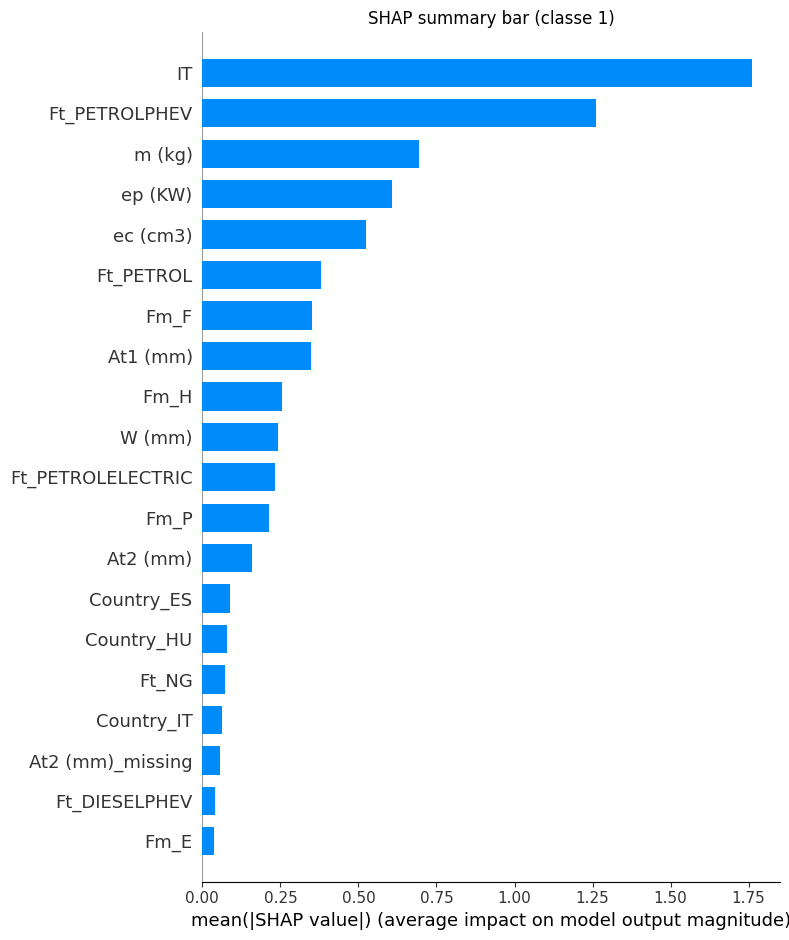

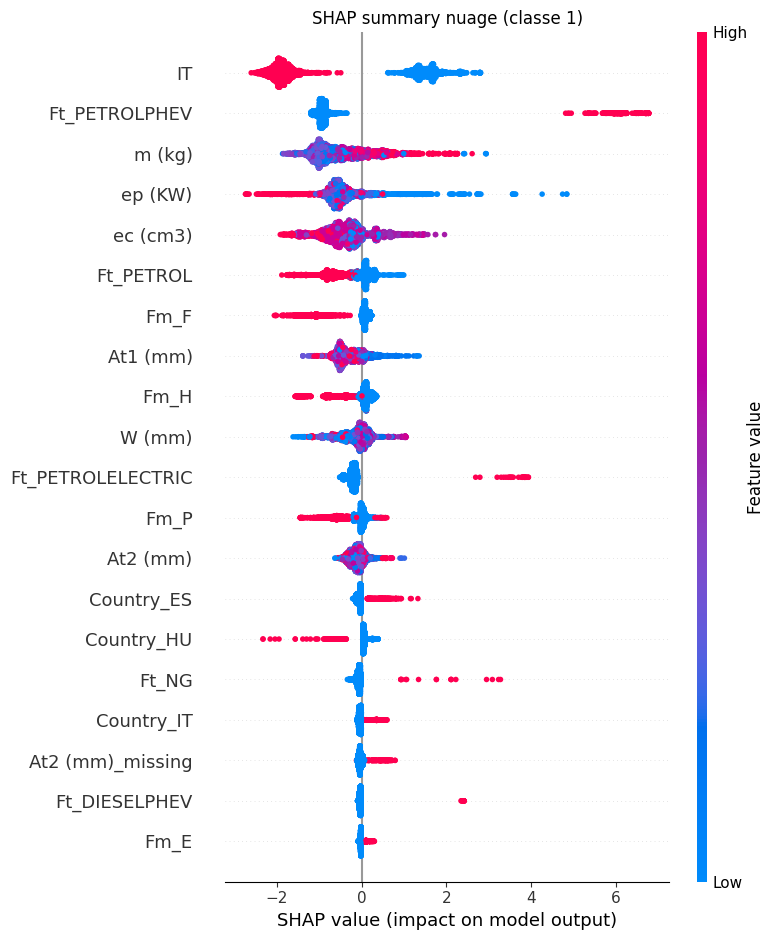

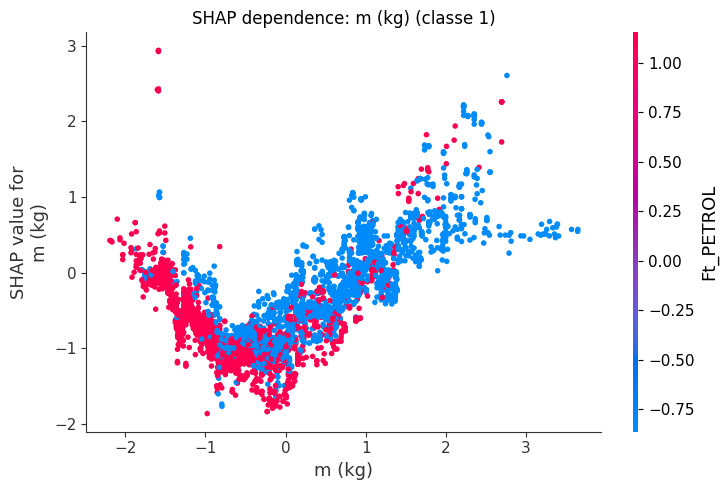

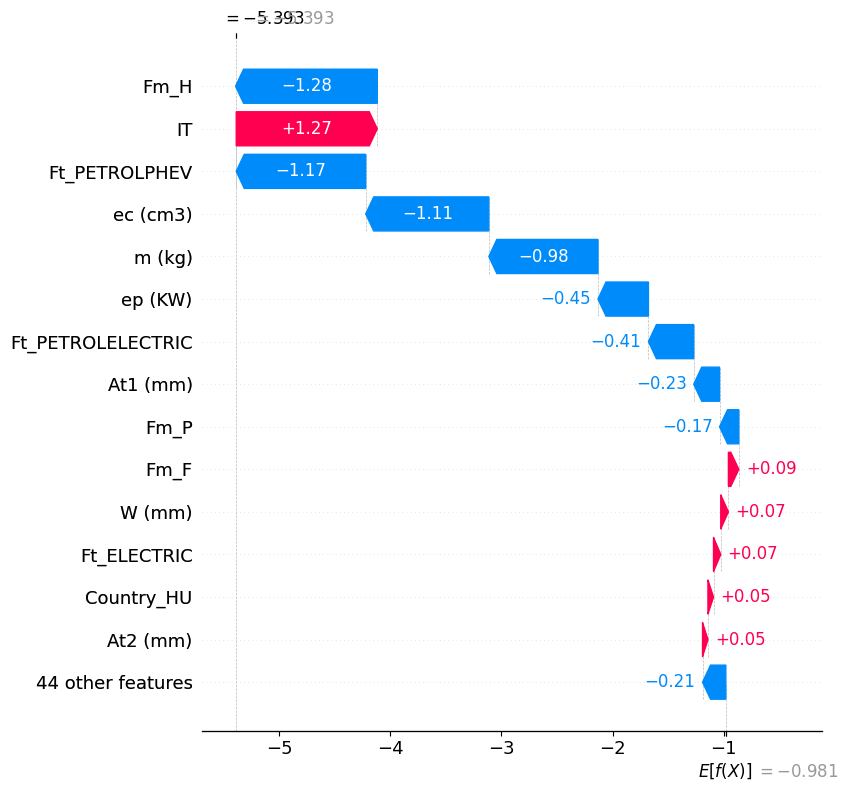

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, shap

final_model = xgb_best 
n_features = X_test.shape[1]
n_classes = len(getattr(final_model, "classes_", np.unique(y_test)))

# Échantillon pour SHAP
rng = np.random.default_rng(42)
sample_size = min(5000, len(X_test))
idx = rng.choice(len(X_test), size=sample_size, replace=False)
X_exp = X_test.iloc[idx]
y_exp = np.ravel(y_test)[idx]

explainer = shap.TreeExplainer(final_model)  # ou shap.TreeExplainer(final_model.get_booster())
explanation = explainer(X_exp, check_additivity=False)
vals = np.array(explanation.values)
print("vals shape:", vals.shape)

def normalize_shap(vals, n_features, n_classes):
    if vals.ndim == 2:  # (N, F) binaire
        return vals[np.newaxis, ...]  # (1, N, F)
    if vals.ndim != 3:
        raise ValueError(f"Shape SHAP inattendue: {vals.shape}")
    dims = vals.shape
    feat_axes = [i for i, d in enumerate(dims) if d == n_features] or [int(np.argmax(dims))]
    f_ax = feat_axes[0]
    cls_axes = [i for i, d in enumerate(dims) if d == n_classes and i != f_ax]
    c_ax = cls_axes[0] if cls_axes else None
    axes_all = [0, 1, 2]
    s_ax = next(a for a in axes_all if a not in [f_ax, c_ax])
    if c_ax is None:
        return np.moveaxis(vals, [s_ax, f_ax], [1, 2])[np.newaxis, ...]
    return np.moveaxis(vals, [c_ax, s_ax, f_ax], [0, 1, 2])

shap_arr = normalize_shap(vals, n_features, n_classes)  # (C, N, F)
print("shap_arr shape (C,N,F):", shap_arr.shape)

# Importance globale |mean|
shap_imp_mean = np.mean(np.abs(shap_arr), axis=(0, 1))
shap_imp_series = pd.Series(shap_imp_mean, index=X_exp.columns).sort_values(ascending=False)
print("Top 20 SHAP (|value| mean, all classes):")
display(shap_imp_series.head(20))

# Classe majoritaire
cls_idx = 1
cls_sv = shap_arr[cls_idx if shap_arr.shape[0] > 1 else 0]

# SHAP bar + nuage
shap.summary_plot(cls_sv, X_exp, plot_type="bar", show=False)
plt.title(f"SHAP summary bar (classe {cls_idx})"); plt.tight_layout(); plt.show()
shap.summary_plot(cls_sv, X_exp, show=False)
plt.title(f"SHAP summary nuage (classe {cls_idx})"); plt.tight_layout(); plt.show()

# Dépendance sur la feature la plus importante
feat_key = shap_imp_series.index[0]
shap.dependence_plot(feat_key, cls_sv, X_exp, show=False)
plt.title(f"SHAP dependence: {feat_key} (classe {cls_idx})"); plt.tight_layout(); plt.show()

# Waterfall local : base_value scalaire pour le point i et la classe prédite
i = 0
cls_pred = 1
sv_pred = shap_arr[cls_pred if shap_arr.shape[0] > 1 else 0]

base_vals = np.array(explanation.base_values)
if base_vals.ndim == 0:
    base = float(base_vals)
elif base_vals.ndim == 1:
    base = float(base_vals[cls_pred]) if base_vals.shape[0] == n_classes else float(base_vals[i])
elif base_vals.ndim == 2:
    # (N, C) ou (C, N)
    if base_vals.shape[0] == len(X_exp) and base_vals.shape[1] == n_classes:
        base = float(base_vals[i, cls_pred])
    elif base_vals.shape[0] == n_classes and base_vals.shape[1] == len(X_exp):
        base = float(base_vals[cls_pred, i])
    else:
        base = float(base_vals.ravel()[0])
else:
    base = float(base_vals.ravel()[0])

shap.plots._waterfall.waterfall_legacy(
    base, sv_pred[i], feature_names=X_exp.columns, max_display=15, show=True
)


##  SHAP – Analyse détaillée focalisée sur la **classe 1** (faibles émissions CO₂)

La classe 1 correspond à des **véhicules à faibles émissions**, immédiatement au-dessus de la classe 0 (zéro émission). Elle constitue une **zone frontière critique** entre les véhicules électriques / très sobres et les véhicules thermiques ou hybrides légers. Les analyses SHAP confirment que le modèle adopte une logique spécifique et cohérente pour cette classe.

---

##  SHAP Summary Bar — Classe 1

**Objectif du graphique**  
Identifier les variables qui influencent le plus fortement l’appartenance à la classe 1, via la moyenne des valeurs absolues SHAP.

**Lecture principale**  
- Les variables dominantes sont :
  - `IT` (innovations technologiques),
  - `Ft_PETROLPHEV`,
  - `m (kg)`,
  - `ep (KW)` et `ec (cm3)`.
- Les dimensions (`At1`, `W`, `At2`) et les modes d’énergie (`Fm_*`) jouent un rôle secondaire mais structurant.
- Les variables pays et indicateurs de données manquantes ont un impact marginal.

**Interprétation**  
Contrairement aux classes intermédiaires, la **classe 1 est fortement influencée par la présence d’innovations technologiques et de motorisations hybrides rechargeables**, qui permettent à des véhicules non électriques d’atteindre de faibles niveaux d’émissions.

**Conclusion explicabilité**  
Le modèle ne définit pas la classe 1 uniquement par une faible masse ou puissance, mais par une **combinaison “technologie + sobriété mécanique”**, ce qui est cohérent avec la réglementation WLTP.

---

##  SHAP Summary (nuage) — Classe 1

**Objectif du graphique**  
Analyser le **sens et la dispersion** des effets des variables sur la prédiction de la classe 1.

**Lecture principale**  
- `IT` :
  - Valeurs élevées (présence d’innovations) génèrent des contributions SHAP **positives**, favorisant fortement la classe 1.
- `Ft_PETROLPHEV` :
  - Effet positif marqué, indiquant que les PHEV sont typiquement positionnés dans cette classe.
- `m (kg)`, `ep (KW)`, `ec (cm3)` :
  - Des valeurs élevées génèrent des contributions **négatives**, éloignant le véhicule de la classe 1.
- Les effets sont globalement **monotones**, sans discontinuité artificielle.

**Interprétation**  
La classe 1 est caractérisée par un **équilibre fragile** :  
les gains technologiques peuvent compenser partiellement des caractéristiques physiques moins favorables, mais seulement dans certaines limites.

**Conclusion explicabilité**  
Le nuage SHAP montre que le modèle apprend des **compromis réalistes**, typiques des véhicules faiblement émetteurs mais non zéro émission.

---

##  SHAP Dependence Plot — `m (kg)` (Classe 1)

**Objectif du graphique**  
Étudier l’effet marginal de la masse sur la probabilité d’appartenance à la classe 1.

**Lecture principale**  
- Relation clairement **non linéaire** :
  - Masse faible à modérée → contribution positive ou neutre.
  - Masse élevée → contribution SHAP fortement négative.
- La coloration par `Ft_PETROL` montre que :
  - à masse équivalente, les véhicules thermiques sont pénalisés plus tôt que les hybrides.

**Interprétation**  
La masse agit comme un **facteur limitant** pour la classe 1 :  
au-delà d’un certain seuil, même les technologies embarquées ne suffisent plus à maintenir le véhicule dans cette catégorie.

**Conclusion explicabilité**  
Le modèle capture correctement une **frontière physique réaliste** entre sobriété énergétique et gabarit du véhicule.

---

##  SHAP Waterfall — Explication locale (classe 1)

**Objectif du graphique**  
Expliquer une prédiction individuelle conduisant à la classe 1, depuis la valeur moyenne du modèle jusqu’au score final.

**Lecture principale**  
- Contributions positives majeures :
  - `IT` (+1.27),
  - certains indicateurs énergétiques secondaires.
- Contributions négatives dominantes :
  - `Fm_H`, `Ft_PETROLPHEV`,
  - `ec (cm3)`, `m (kg)`, `ep (KW)`.

**Interprétation**  
La prédiction résulte d’un **arbitrage fin** :
- les innovations technologiques poussent vers la classe 1,
- mais la cylindrée, la masse et la puissance tirent la prédiction vers des classes plus élevées.

**Conclusion explicabilité**  
Cette explication locale illustre parfaitement la **logique de compromis** propre à la classe 1 et la capacité du modèle à justifier chaque décision.

---

##  SHAP global (|SHAP| moyen) — Cohérence inter-classes

**Lecture principale**  
- Les variables globalement les plus importantes restent :
  - `m (kg)`,
  - `ec (cm3)`,
  - `ep (KW)`,
  - suivies des dimensions et du carburant.
- Pour la classe 1, `IT` et `Ft_PETROLPHEV` remontent fortement dans le classement par rapport aux classes intermédiaires.

**Interprétation**  
Cela confirme que :
- certaines variables sont **universelles** (physiques),
- d’autres sont **spécifiquement discriminantes** pour les classes basses.

---

##  Synthèse explicabilité — Classe 1

- La classe 1 est définie par un **équilibre entre innovation technologique et sobriété mécanique**.
- Le modèle distingue clairement :
  - la classe 0 (zéro émission),
  - la classe 1 (faibles émissions grâce à la technologie),
  - la classe 2+ (émissions plus structurelles).
- Les effets sont monotones, physiquement plausibles et cohérents avec la réglementation WLTP.
- Les erreurs potentielles autour de la frontière 1 ↔ 2 sont **explicables et attendues**.

> L’explicabilité SHAP confirme que le modèle traite la classe 1 comme une **classe de transition**, ce qui renforce la crédibilité métier et réglementaire du modèle.


vals shape: (5000, 58, 8)
shap_arr shape (C,N,F): (8, 5000, 58)


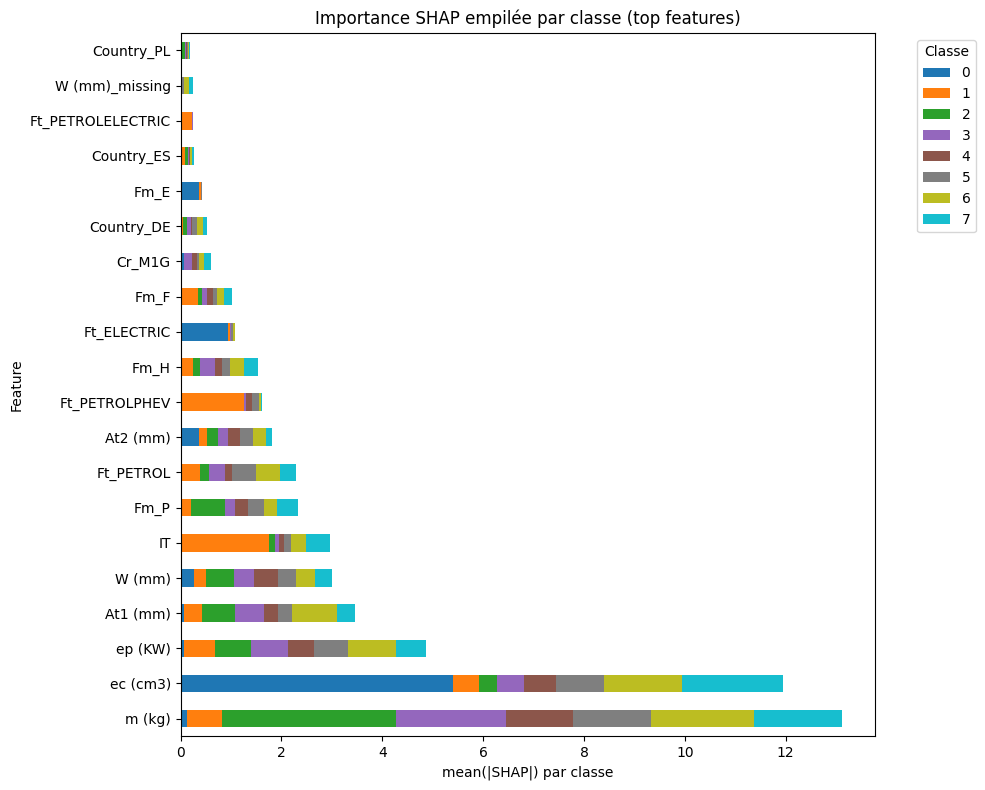

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, shap

final_model = xgb_best  # change si besoin
classes = list(getattr(final_model, "classes_", np.unique(y_test)))
n_features = X_test.shape[1]

# Échantillon pour accélérer
rng = np.random.default_rng(42)
sample_size = min(5000, len(X_test))
idx = rng.choice(len(X_test), size=sample_size, replace=False)
X_exp = X_test.iloc[idx]

# SHAP multi-classe
explainer = shap.Explainer(final_model)
explanation = explainer(X_exp, check_additivity=False)
vals = np.array(explanation.values)
print("vals shape:", vals.shape)

def normalize_shap(vals, n_features, n_classes):
    if vals.ndim == 2:  # (N, F)
        return vals[np.newaxis, ...]  # (1, N, F)
    if vals.ndim != 3:
        raise ValueError(f"Shape SHAP inattendue: {vals.shape}")
    dims = vals.shape
    feat_axes = [i for i, d in enumerate(dims) if d == n_features] or [int(np.argmax(dims))]
    f_ax = feat_axes[0]
    cls_axes = [i for i, d in enumerate(dims) if d == n_classes and i != f_ax]
    c_ax = cls_axes[0] if cls_axes else None
    s_ax = next(a for a in [0,1,2] if a not in [f_ax, c_ax])
    if c_ax is None:
        return np.moveaxis(vals, [s_ax, f_ax], [1, 2])[np.newaxis, ...]
    return np.moveaxis(vals, [c_ax, s_ax, f_ax], [0, 1, 2])

shap_arr = normalize_shap(vals, n_features, len(classes))  # (C, N, F)
print("shap_arr shape (C,N,F):", shap_arr.shape)

# Moyenne des |SHAP| par classe
imp_per_class = []
for c in range(shap_arr.shape[0]):
    imp = np.mean(np.abs(shap_arr[c]), axis=0)
    imp_per_class.append(pd.Series(imp, index=X_exp.columns, name=classes[c]))
imp_df = pd.DataFrame(imp_per_class)
imp_df.index = classes

# Top features (total sur toutes classes)
top_k = 20
total_imp = imp_df.sum(axis=0).sort_values(ascending=False)
top_feats = total_imp.head(top_k).index.tolist()

# Tableau pour plot (features en lignes, classes en colonnes)
df_plot = imp_df[top_feats].T  # index = features, colonnes = classes
order = df_plot.sum(axis=1).sort_values(ascending=False).index
df_plot = df_plot.loc[order]

# Plot stacked bar horizontal
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', len(classes))
df_plot.plot(
    kind='barh', stacked=True, ax=ax,
    color=[colors(i) for i in range(len(classes))]
)
ax.set_xlabel("mean(|SHAP|) par classe")
ax.set_ylabel("Feature")
ax.set_title("Importance SHAP empilée par classe (top features)")
ax.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##  Importance SHAP empilée par classe (vue comparative)

**Objectif du graphique**  
Ce graphique compare l’importance des variables **pour chaque classe**, via des barres empilées représentant la moyenne des valeurs absolues SHAP.

**Lecture principale**  
- `m (kg)` et `ec (cm3)` sont déterminantes pour **toutes les classes**, avec une importance croissante vers les classes élevées.
- Les variables de carburant différencient fortement :
  - les classes basses (0, 1),
  - des classes intermédiaires et élevées.
- Les dimensions jouent un rôle transversal mais secondaire.

**Interprétation**  
Certaines variables sont **universelles** (masse, cylindrée), tandis que d’autres sont **discriminantes par classe** (carburant, hybridation).

**Conclusion explicabilité**  
Cette vue confirme que le modèle apprend une **structure globale cohérente**, tout en adaptant ses décisions aux spécificités de chaque classe CO₂.

---

##  Synthèse globale explicabilité SHAP

- Les décisions du modèle sont pilotées par des **facteurs physiques et énergétiques plausibles**.
- Les effets sont monotones, continus et cohérents avec la réglementation.
- Les erreurs se concentrent logiquement aux **frontières de classes**.
- Le modèle est à la fois **performant, explicable et fiable**.

Ces résultats valident pleinement l’utilisation de XGBoost comme solution de classification CO₂ dans un contexte professionnel et réglementaire.
